In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [16]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Water Level/TDWL/Khulna-Rupsha.csv')
#the daily dataset
print(df.shape)
df.head()

(17259, 4)


,Date,Max_WL(m),Min_WL(m),WL(m)
0,1962-04-01,1.52,-0.18,0.670
1,1962-04-02,1.58,-0.15,0.715
2,1962-04-03,1.95,-0.21,0.870
3,1962-04-04,2.01,-0.34,0.835
4,1962-04-05,1.98,-0.30,0.840


In [17]:
#checking types
#checking types
df.pop('Max_WL(m)')
df.pop('Min_WL(m)')
df.dtypes

Date      object
WL(m)    float64
dtype: object

Data Preprocessing
---------

In [18]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

             Date  WL(m)
0      1962-04-01  0.670
1      1962-04-02  0.715
2      1962-04-03  0.870
3      1962-04-04  0.835
4      1962-04-05  0.840
...           ...    ...
17254  2019-04-26  0.880
17255  2019-04-27  0.880
17256  2019-04-28  0.955
17257  2019-04-29  0.975
17258  2019-04-30  1.020

[17259 rows x 2 columns]


In [19]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [20]:
df.head()

,Date,WL(m)
0,1962-04-01,0.670
1,1962-04-02,0.715
2,1962-04-03,0.870
3,1962-04-04,0.835
4,1962-04-05,0.840


In [21]:
df.tail()

,Date,WL(m)
17254,2019-04-26,0.880
17255,2019-04-27,0.880
17256,2019-04-28,0.955
17257,2019-04-29,0.975
17258,2019-04-30,1.020


In [22]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
# df_pr.sort_values('Date', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('Date', inplace=True)
df_pr.head()

,WL(m)
Date,
1962-04-01,0.670
1962-04-02,0.715
1962-04-03,0.870
1962-04-04,0.835
1962-04-05,0.840


In [23]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Khulna-Rupsha_monthly.csv")

(685, 1)


In [24]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1962-04-30 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 685
Total year: 57


Data Visulalization
----------

About Data

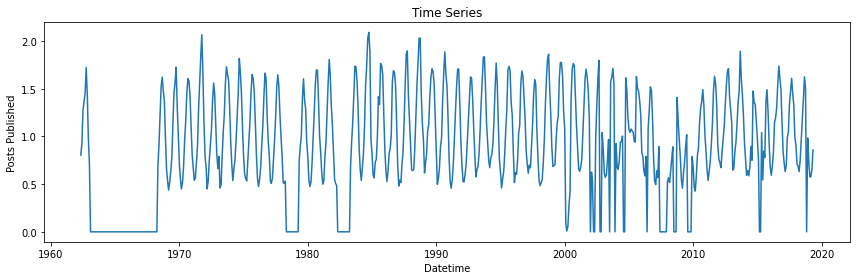

In [25]:
# 7.Plotting the time series
monthly['WL(m)'] = monthly['WL(m)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(573, 1), Validation=(112, 1)


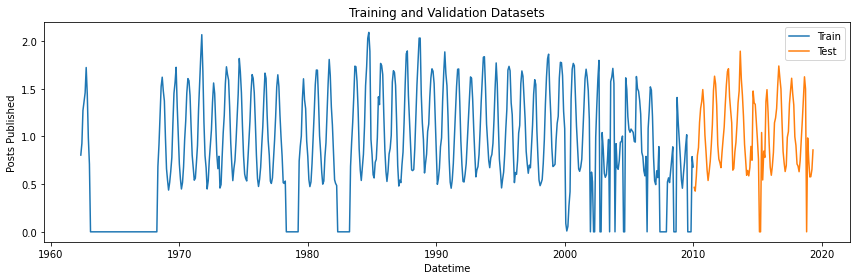

In [26]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [27]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [28]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

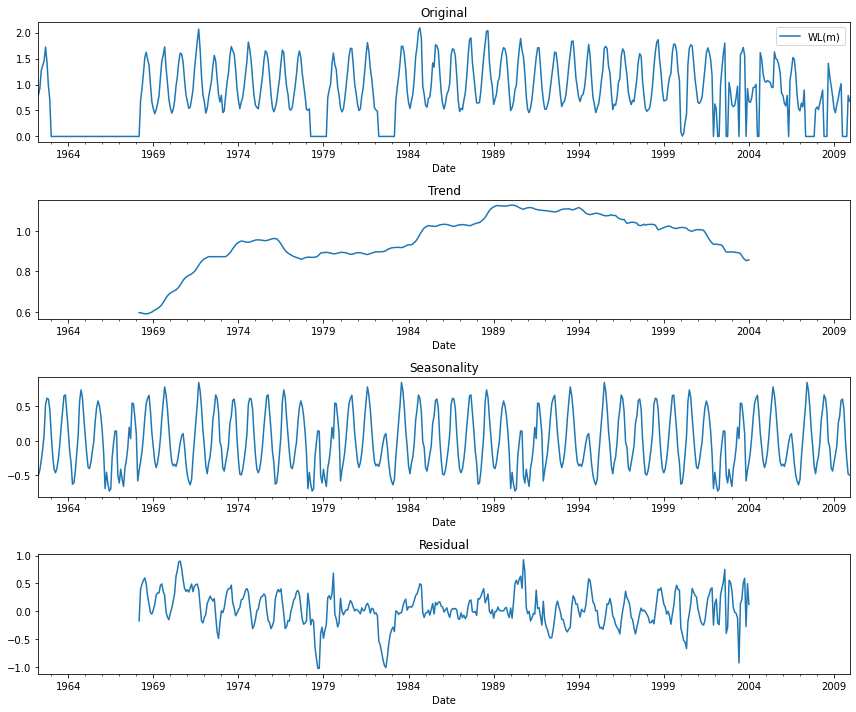

In [29]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [30]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

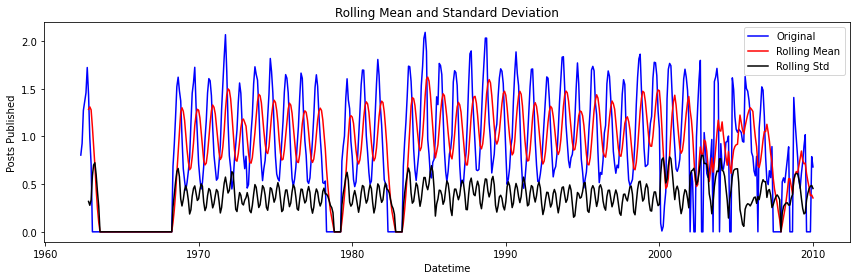

Results of Dickey-Fuller Test:
Test Statistic                  -3.982509
P-Value                          0.001505
#Lags Used                      15.000000
Number of Observations Used    557.000000
Critical Value (1%)             -3.442145
Critical Value (5%)             -2.866743
Critical Value (10%)            -2.569541
dtype: float64


In [31]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [32]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [33]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  WL(m)   No. Observations:                  573
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 -37.634
Date:                Sun, 06 Nov 2022   AIC                             93.269
Time:                        19:43:07   BIC                            132.411
Sample:                    04-30-1962   HQIC                           108.538
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4883      0.072      6.828      0.000       0.348       0.628
ar.L2         -0.0867      0.033     -2.653      0.008      -0.151      -0.023
ar.L3         -0.0618      0.040     -1.562      0.1

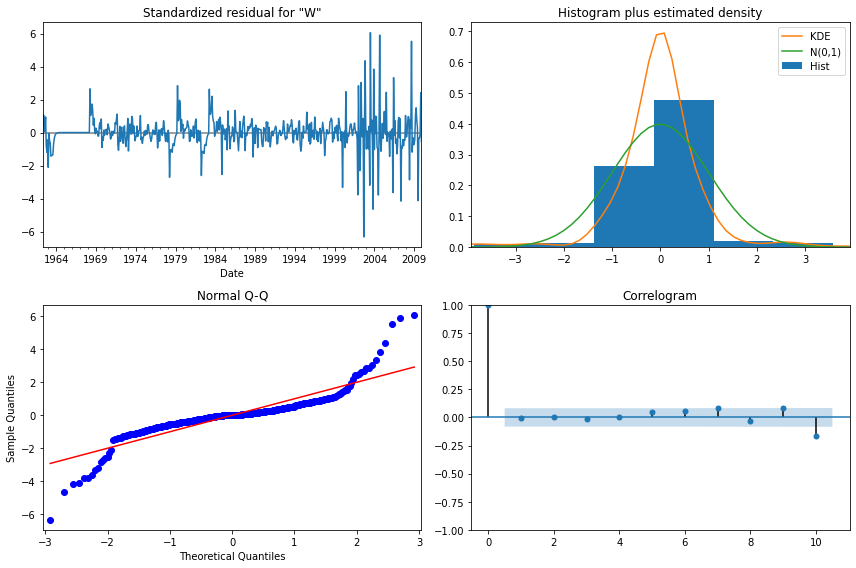

In [34]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

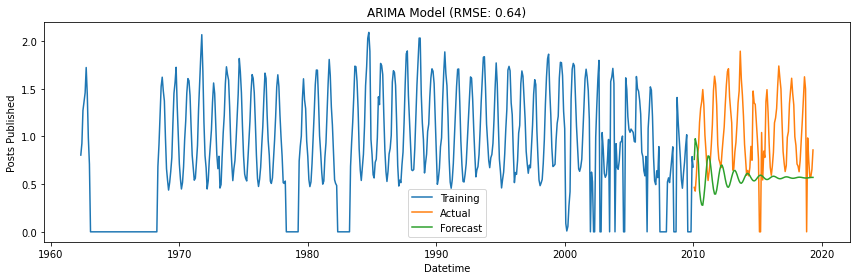

In [35]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [36]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31    0.759145
2010-02-28    0.976381
2010-03-31    0.924090
2010-04-30    0.870885
2010-05-31    0.706177
                ...   
2018-12-31    0.566691
2019-01-31    0.568404
2019-02-28    0.569783
2019-03-31    0.570509
2019-04-30    0.570454
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [37]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  0.6354217914648042


---------------------

SARIMAX MODEL

In [38]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [39]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              WL(m)   No. Observations:                  573
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 -23.883
Date:                            Sun, 06 Nov 2022   AIC                             81.766
Time:                                    19:44:36   BIC                            155.340
Sample:                                04-30-1962   HQIC                           110.495
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4855      0.096      5.064      0.000       0.298       0.673
ar.L2         -0.0758      0.034   

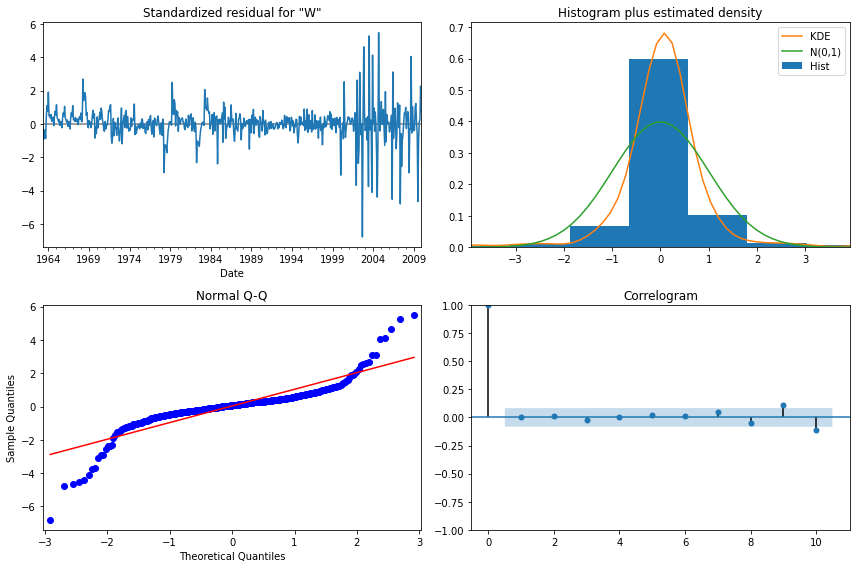

In [40]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

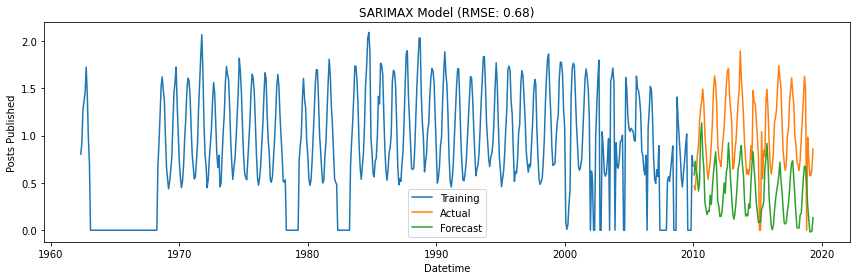

In [41]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [42]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31    0.585986
2010-02-28    0.729166
2010-03-31    0.615490
2010-04-30    0.561007
2010-05-31    0.413881
                ...   
2018-12-31    0.116616
2019-01-31   -0.016368
2019-02-28   -0.016853
2019-03-31   -0.006698
2019-04-30    0.132241
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [43]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.6773224221595391


-----------------------

PROPHET

In [44]:
#Reading monthly data 
df= pd.read_csv("Khulna-Rupsha_monthly.csv")

In [45]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1962-04-30,0.804333
1,1962-05-31,0.927258
2,1962-06-30,1.272333
3,1962-07-31,1.363387
4,1962-08-31,1.456774


In [46]:
#prophet model Implement
prophet_model = Prophet()

In [47]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpczr5a3m1/849_xmaj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpczr5a3m1/dhp2idzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70315', 'data', 'file=/tmp/tmpczr5a3m1/849_xmaj.json', 'init=/tmp/tmpczr5a3m1/dhp2idzh.json', 'output', 'file=/tmp/tmpczr5a3m1/prophet_model5c_ewhfs/prophet_model-20221106194438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1962-04-30
1   1962-05-31
2   1962-06-30
3   1962-07-31
4   1962-08-31
..         ...
752 2024-12-31
753 2025-01-31
754 2025-02-28
755 2025-03-31
756 2025-04-30

[757 rows x 1 columns]


In [49]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-04-30,0.984523,0.535869,0.907220,0.984523,0.984523,-0.257524,-0.257524,-0.257524,-0.257524,-0.257524,-0.257524,0.0,0.0,0.0,0.726999
1,1962-05-31,0.984887,0.692478,1.056098,0.984887,0.984887,-0.105751,-0.105751,-0.105751,-0.105751,-0.105751,-0.105751,0.0,0.0,0.0,0.879136
2,1962-06-30,0.985239,0.946206,1.304079,0.985239,0.985239,0.140404,0.140404,0.140404,0.140404,0.140404,0.140404,0.0,0.0,0.0,1.125644
3,1962-07-31,0.985603,1.229770,1.583551,0.985603,0.985603,0.419347,0.419347,0.419347,0.419347,0.419347,0.419347,0.0,0.0,0.0,1.404951
4,1962-08-31,0.985967,1.431550,1.792098,0.985967,0.985967,0.632511,0.632511,0.632511,0.632511,0.632511,0.632511,0.0,0.0,0.0,1.618478


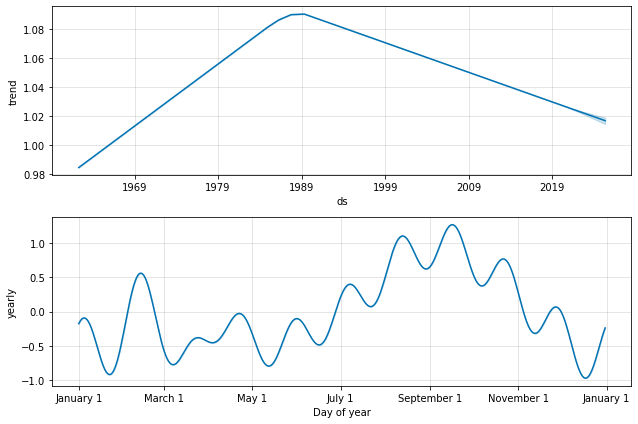

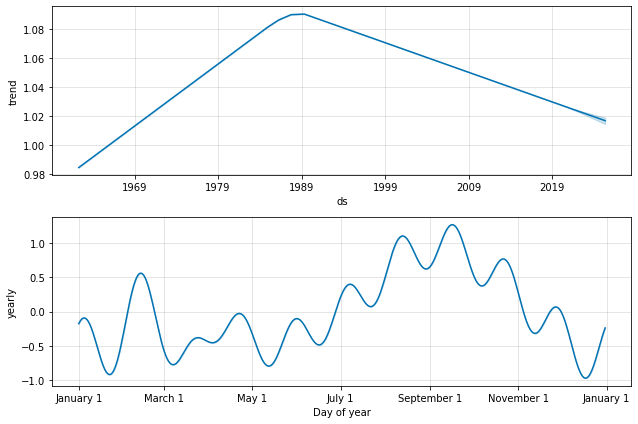

In [50]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [51]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                yhat
ds                  
1962-04-30  0.726999
1962-05-31  0.879136
1962-06-30  1.125644
1962-07-31  1.404951
1962-08-31  1.618478
...              ...
2024-12-31  0.793892
2025-01-31  0.606198
2025-02-28  0.512854
2025-03-31  0.583468
2025-04-30  0.745681

[757 rows x 1 columns]


In [52]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1962-04-30    0.726999
1962-05-31    0.879136
1962-06-30    1.125644
1962-07-31    1.404951
1962-08-31    1.618478
                ...   
2024-12-31    0.793892
2025-01-31    0.606198
2025-02-28    0.512854
2025-03-31    0.583468
2025-04-30    0.745681
Name: yhat, Length: 757, dtype: float64


In [53]:
print(valid)

               WL(m)
Date                
2010-01-31  0.465484
2010-02-28  0.426607
2010-03-31  0.583548
2010-04-30  0.800833
2010-05-31  0.882419
...              ...
2018-12-31  0.742581
2019-01-31  0.575161
2019-02-28  0.578571
2019-03-31  0.654516
2019-04-30  0.858167

[112 rows x 1 columns]


In [54]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [55]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.2302956420745724


-----------------

MODEL Comparison
----------

Testing

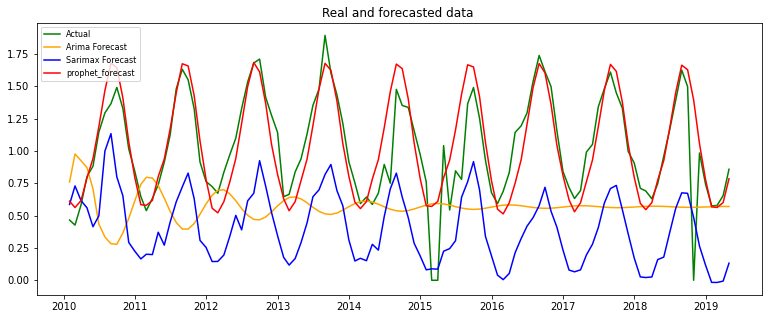

In [56]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

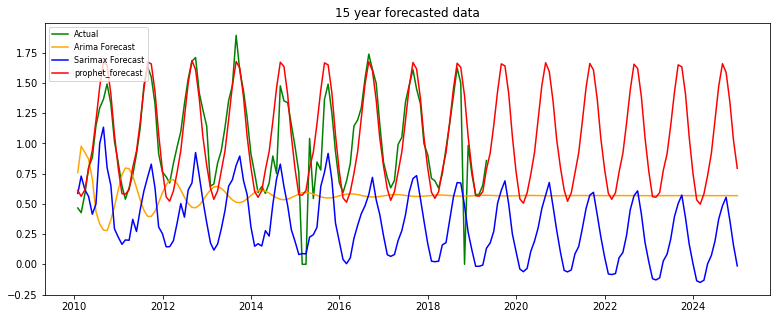

In [57]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

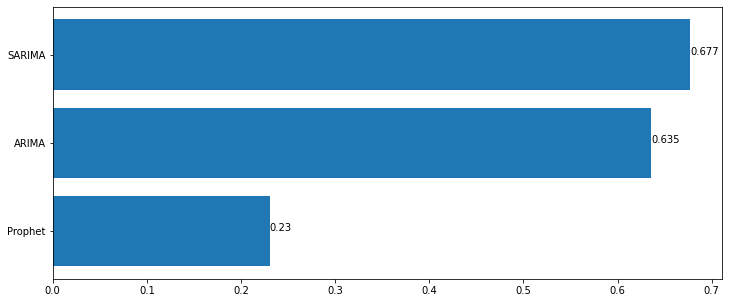

In [58]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [59]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2018-12-31

Great! Now choose the model result you want to see for 2018-12-31
 1.Arima 
 2.Sarimax
 3.Prophet
 2
Choosen Model is Sarimax
In 2018-12-31 rainfall value for Sarimax model:  0.11661642502540051


In [60]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Khulna-Rupsha-monthly_merged.csv")